In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import random
from itertools import chain

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Digit data loading 


In [ ]:
training_data = pd.read_csv("/content/drive/MyDrive/data/digitdata/trainingimages",skip_blank_lines=False, header=None,squeeze  = True)
training_labels  = pd.read_csv("/content/drive/MyDrive/data/digitdata/traininglabels",skip_blank_lines=False, header=None)
test_images = pd.read_csv("/content/drive/MyDrive/data/digitdata/testimages",skip_blank_lines=False, header=None,squeeze  = True)
test_labels = pd.read_csv("/content/drive/MyDrive/data/digitdata/testlabels",skip_blank_lines=False, header=None)


In [ ]:
print(training_data[0:28], test_images[0:28])

0                                 
1                                 
2                                 
3                                 
4                                 
5                     +++++##+    
6             +++++######+###+    
7            +##########+++++     
8             #######+##          
9             +++###  ++          
10               +#+              
11               +#+              
12                +#+             
13                +##++           
14                 +###++         
15                  ++##++        
16                    +##+        
17                     ###+       
18                  +++###        
19                ++#####+        
20              ++######+         
21            ++######+           
22           +######+             
23        ++######+               
24        +####++                 
25                                
26                                
27                                
Name: 0, dtype: obje

Each image in digit data is described as 28*28 pixel image. Which can be mapped 

In [ ]:
def transform_data(data):
    data_temp = data.copy()
    for i in range(data_temp.shape[0]):
        data_temp[i] = data_temp[i].replace(' ', '0').replace('#', '1').replace('+', '1')
    data_temp = data_temp.apply(lambda x: pd.Series(list(x)))
    data_temp = data_temp.apply(pd.to_numeric)
    return data_temp

train_digit_data= transform_data(training_data)
test_digit_data=transform_data(test_images)


In [ ]:
# Selecting 4x4 pixel blocks and their number of color pixels(1) as features
def colorpixelcount(df, image_height, feature_size):
    count_list=[]
   
    for i in range(int(image_height/feature_size)):
        for j in range(int(df.shape[1]/feature_size)):
            count=0
            for k in range((i*feature_size),(i*feature_size)+feature_size):
                for l in range((j*feature_size),(j*feature_size)+feature_size):
                    if df.iloc[k,l]==1:
                        count=count+1
            count_list.append(count)
  
    return count_list

def perceptron_features(data_temp, image_height, feature_size):

    feat_list=[]
    re = 0
    while re<int(len(data_temp)/image_height):  
        
        temp=colorpixelcount(data_temp.iloc[(image_height*re):(image_height*(re+1)),:].reset_index(drop=True), image_height, feature_size)
        feat_list.append(temp)
        re=re+1
    return feat_list



In [ ]:
def perceptron_train(data_for_train, classes, iterations, labels,image_height, feature_size):
    
    start_time = time.time()
    perc_features = np.asarray(perceptron_features(data_for_train, image_height, feature_size))
    weights = np.ones((classes,perc_features.shape[1]))
    trained_vector = np.zeros((classes,1))
 
    for _ in range(iterations):
        for image_no in range(len(labels)):
            temp_output = np.dot(perc_features[image_no], weights.T)
            
            # get the highest predicted class value from the predicted 
            class_temp = np.where(max(temp_output) == temp_output)[0][0]
            if class_temp != labels[image_no]:
                weights[class_temp] -= perc_features[image_no]
                weights[labels[image_no]] += perc_features[image_no]
                
    end_time = time.time()
    return weights, end_time-start_time
            
       

In [ ]:
def perceptron_test(test_digit_data,weights, test_labels, image_height, feature_size):
    
    perc_test_features = np.asarray(perceptron_features(test_digit_data,image_height, feature_size))
    labels = np.asarray(test_labels)

    misclassified = 0
    for image_no in range(len(test_labels)):
        predict_array = np.dot(perc_test_features[image_no],weights.T)

        class_temp = np.where(max(predict_array) == predict_array)[0][0]

        if class_temp != labels[image_no][0]:
            misclassified += 1
    return (1 - misclassified/len(labels))*100
        
        
# accuracy = 1 - perceptron_test(weights,test_labels)    
# accuracy





  0%|          | 0/10 [00:00<?, ?it/s]



 10%|█         | 1/10 [01:40<15:06, 100.75s/it]



 20%|██        | 2/10 [03:51<14:38, 109.82s/it]



 30%|███       | 3/10 [06:37<14:45, 126.46s/it]



 40%|████      | 4/10 [09:53<14:45, 147.56s/it]



 50%|█████     | 5/10 [13:43<14:20, 172.20s/it]



 60%|██████    | 6/10 [18:08<13:20, 200.12s/it]



 70%|███████   | 7/10 [23:07<11:29, 229.71s/it]



 80%|████████  | 8/10 [28:39<08:40, 260.31s/it]



 90%|█████████ | 9/10 [34:41<04:51, 291.02s/it]



100%|██████████| 10/10 [41:15<00:00, 247.51s/it]


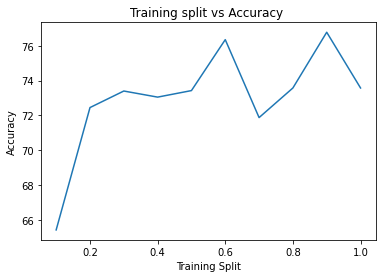

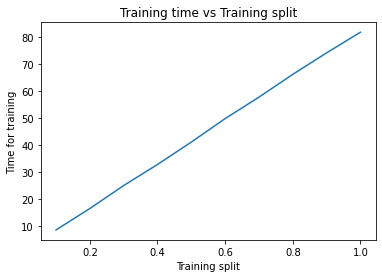

,Training_split,Mean(Accuracy) (%),Std(Accuracy) (%),Training Time (sec)
0,10,65.425,3.745,8.427
1,20,72.450,2.033,16.392
2,30,73.400,1.294,24.931
3,40,73.050,1.795,32.762
4,50,73.425,2.046,41.091
5,60,76.350,4.633,49.824
6,70,71.875,1.308,57.791
7,80,73.575,3.318,66.268
8,90,76.775,3.932,74.260
9,100,73.575,1.874,81.931


In [ ]:
def perceptron_digit(classes,image_height, feature_size):
    ratio = np.arange(0.1,1.1,0.1)
    accuracies = []
    std_accuracies = []
    times = []
    
    for value in tqdm(ratio):

        times_inner = []
        accuracies_inner =[]
        
        for _ in range(4):
            
            num_samples  =  training_labels.shape[0]
            data_random_samples = random.sample(range(num_samples), int(value * num_samples))
            data_sample_range = [ range(i * image_height, (i+1)*image_height)  for i in data_random_samples]
            data_sample_range = list(chain(*data_sample_range))
                        
            data_for_train = train_digit_data.iloc[data_sample_range]
            labels_for_train = (np.asarray(training_labels)[data_random_samples])

            weights, time = perceptron_train(data_for_train,classes,3,labels_for_train, image_height, feature_size) 
            times_inner.append(time)
            accuracies_inner.append(perceptron_test(test_digit_data,weights, test_labels, image_height, feature_size))
            
        accuracies.append(round(np.mean(accuracies_inner),3))
        std_accuracies.append(round(np.std(accuracies_inner),3))
        times.append(round(np.mean(times_inner),3))
    
    training_split = np.array([ 10 * i for i in range(1,11,1)])
    final_results = pd.DataFrame(list(zip(training_split,accuracies, std_accuracies, times)),
                                 columns = ['Training_split','Mean(Accuracy) (%)', 'Std(Accuracy) (%)','Training Time (sec)'])
   
    
    plt.plot(ratio,accuracies )
    plt.title("Training split vs Accuracy ")
    plt.xlabel("Training Split")
    plt.ylabel("Accuracy")
    plt.show()
    plt.plot(ratio,times )
    plt.title("Training time vs Training split")
    plt.xlabel("Training split")
    plt.ylabel("Time for training")
    plt.show()
    
    return final_results
perceptron_digit(10,28,4)

Face classification for Perceptron

In [ ]:
training_face_data = pd.read_csv("/content/drive/MyDrive/data/facedata/facedatatrain",skip_blank_lines=False, header=None,squeeze  = True)
training_face_labels  = pd.read_csv("/content/drive/MyDrive/data/facedata/facedatatrainlabels",skip_blank_lines=False, header=None)
test_face_images = pd.read_csv("/content/drive/MyDrive/data/facedata/facedatatest",skip_blank_lines=False, header=None,squeeze  = True)
test_face_labels = pd.read_csv("/content/drive/MyDrive/data/facedata/facedatatestlabels",skip_blank_lines=False, header=None)
# validation_face_images = pd.read_csv("C:\\Users\\Srikar Reddy\\Desktop\\Project\\facedata\\facedatavalidation",skip_blank_lines=False, header=None,squeeze  = True)
# validation_face_labels = pd.read_csv("C:\\Users\\Srikar Reddy\\Desktop\\Project\\facedata\\facedatavalidationlabels",skip_blank_lines=False, header=None)



face_data_train = transform_data(training_face_data)
face_data_test = transform_data(test_face_images)

In [ ]:
print(face_data_train.shape)
print(training_face_labels.shape)

(31570, 60)
(451, 1)






  0%|          | 0/10 [00:00<?, ?it/s]



 10%|█         | 1/10 [01:07<10:07, 67.55s/it]



 20%|██        | 2/10 [02:30<09:36, 72.06s/it]



 30%|███       | 3/10 [04:08<09:19, 79.91s/it]



 40%|████      | 4/10 [06:02<09:01, 90.20s/it]



 50%|█████     | 5/10 [08:11<08:29, 101.93s/it]



 60%|██████    | 6/10 [10:36<07:38, 114.67s/it]



 70%|███████   | 7/10 [13:17<06:26, 128.77s/it]



 80%|████████  | 8/10 [16:15<04:46, 143.37s/it]



 90%|█████████ | 9/10 [19:26<02:37, 157.79s/it]



100%|██████████| 10/10 [22:56<00:00, 137.67s/it]


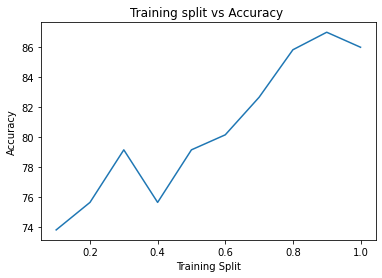

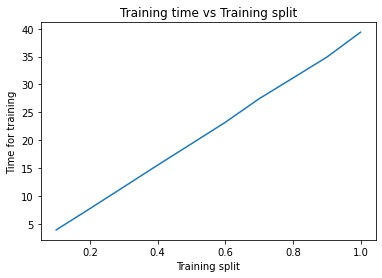

,Training_ratio,Mean(Accuracy) %,Std(Accuracy) %,Training Time (sec)
0,10,73.833,6.623,3.914
1,20,75.667,3.958,7.741
2,30,79.167,1.518,11.629
3,40,75.667,4.123,15.533
4,50,79.167,4.093,19.362
5,60,80.167,5.723,23.213
6,70,82.667,2.357,27.432
7,80,85.833,3.346,31.151
8,90,87.000,4.123,34.888
9,100,86.000,4.447,39.366


In [ ]:
def perceptron_face(classes,image_size, feature_size):
    
    accuracies = []
    std_accuracies = []
    times = []
    ratio = np.arange(0.1,1.05,0.1)
    
    for value in tqdm(ratio):
    
        times_inner = []
        accuracies_inner =[]
        
        for _ in range(4):
            
            num_samples  =  training_face_labels.shape[0]
            data_random_samples = random.sample(range(num_samples), int(value * num_samples))
            data_sample_range = [ range(i * image_size, (i+1)*image_size)  for i in data_random_samples]
            data_sample_range = list(chain(*data_sample_range))
                        
            data_face_train = face_data_train.iloc[data_sample_range]
            labels_for_train = (np.asarray(training_face_labels)[data_random_samples])

            weights, time = perceptron_train(data_face_train,classes,1,labels_for_train, image_size, feature_size) 
            times_inner.append(time)
            accuracies_inner.append(perceptron_test(face_data_test,weights, test_face_labels, image_size, feature_size))
            
        accuracies.append(round(np.mean(accuracies_inner),3))
        std_accuracies.append(round(np.std(np.array(accuracies_inner)),3))
        times.append(round(np.mean(times_inner),3))
        
    training_split = np.array([ 10 *i for i in range(1,11,1)])
    final_results = pd.DataFrame(list(zip(training_split, accuracies, std_accuracies, times)),
                  columns = ['Training_ratio','Mean(Accuracy) %', 'Std(Accuracy) %', 'Training Time (sec)'])
   
        
    plt.plot(ratio,accuracies )
    plt.title("Training split vs Accuracy ")
    plt.xlabel("Training Split")
    plt.ylabel("Accuracy")
    plt.show()
    plt.plot(ratio,times )
    plt.title("Training time vs Training split")
    plt.xlabel("Training split")
    plt.ylabel("Time for training")
    plt.show()
    
    return final_results
        
#
perceptron_face(2,70,2)

In [ ]:
training_data = pd.read_csv("/content/drive/MyDrive/data/digitdata/trainingimages",skip_blank_lines=False, header=None,squeeze  = True)
training_labels  = pd.read_csv("/content/drive/MyDrive/data/digitdata/traininglabels",skip_blank_lines=False, header=None)
test_images = pd.read_csv("/content/drive/MyDrive/data/digitdata/testimages",skip_blank_lines=False, header=None,squeeze  = True)
test_labels = pd.read_csv("/content/drive/MyDrive/data/digitdata/testlabels",skip_blank_lines=False, header=None)
# validation_images = pd.read_csv("C:\\Users\\Srikar Reddy\\Desktop\\Project\\digitdata\\validationimages",skip_blank_lines=False, header=None,squeeze  = True)
# validation_labels = pd.read_csv("C:\\Users\\Srikar Reddy\\Desktop\\Project\\digitdata\\validationlabels",skip_blank_lines=False, header=None)

In [ ]:
train_digit_data= transform_data(training_data)
test_digit_data=transform_data(test_images)

In [ ]:
train_digit_data.shape

(140000, 28)

We are not extracting the features separately here, which would mean each pixel is considered as an individual feature.






  0%|          | 0/10 [00:00<?, ?it/s]



 10%|█         | 1/10 [00:13<01:57, 13.03s/it]



 20%|██        | 2/10 [00:34<02:04, 15.61s/it]



 30%|███       | 3/10 [01:04<02:19, 19.89s/it]



 40%|████      | 4/10 [01:42<02:31, 25.27s/it]



 50%|█████     | 5/10 [02:28<02:37, 31.46s/it]



 60%|██████    | 6/10 [03:22<02:32, 38.15s/it]



 70%|███████   | 7/10 [04:23<02:15, 45.13s/it]



 80%|████████  | 8/10 [05:33<01:45, 52.59s/it]



 90%|█████████ | 9/10 [06:50<01:00, 60.08s/it]



100%|██████████| 10/10 [08:16<00:00, 49.68s/it]


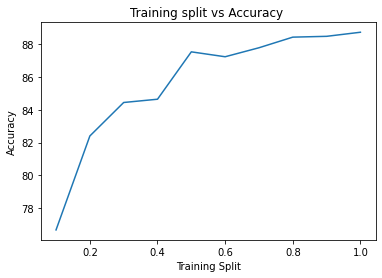

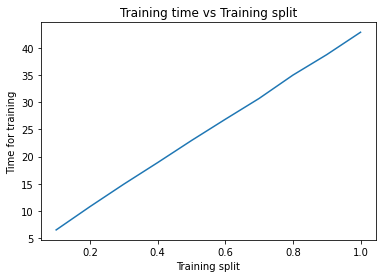

,Training_split,Mean(Accuracy) %,Standard Deviation(Accuracy) %,Training Time (sec)
0,20,76.65,0.45,6.515740
1,30,82.40,0.00,10.803078
2,40,84.45,0.05,14.933939
3,50,84.65,0.25,18.898242
4,60,87.55,0.25,22.956537
5,70,87.25,0.25,26.867877
6,80,87.80,0.00,30.699955
7,90,88.45,0.05,34.993140
8,100,88.50,0.20,38.759202
9,110,88.75,0.05,42.882393


In [ ]:
def knn_digit(train_data,k,image_height):

    train_shape = train_data.shape
    test_shape = test_digit_data.shape
    num_images = training_labels.shape[0]
    testing_num_images = test_labels.shape[0]

    # converting the testdata into numpy array and flattened for calculations
    
    test_dig_np = np.zeros(shape = (testing_num_images, test_shape[1]*image_height))

    for i in range(testing_num_images):
        test_dig_np[i] = test_digit_data.iloc[i*image_height:(i+1)*image_height,:].to_numpy().flatten()

    accuracy = []
    accuracy_std = []
    time_list = []
    
    ratio = np.arange(0.1,1.05,0.1)
    
    # flatten the training dataset
    for split in tqdm(ratio):
        accuracy_inner = []
        time_inner = []
        for _ in range(2):
            train_dig_np = np.zeros(shape=(int((train_shape[0]/image_height)*split),train_shape[1]*image_height))
            start_time = time.time()
            
            num_samples  =  training_labels.shape[0]
            data_random_samples = random.sample(range(num_samples), int(split * num_samples))
            data_sample_range = [ range(i * image_height, (i+1)*image_height)  for i in data_random_samples]
            data_sample_range = list(chain(*data_sample_range))                       
            train_temp_data = train_data.iloc[data_sample_range,:]      
            for i in range(int(num_images*split)):                                
                train_dig_np[i] = train_temp_data[i*image_height:(i+1)*image_height].to_numpy().flatten()

            error = 0
            for image_no in range(testing_num_images):

                each_image = test_digit_data[image_no*image_height:(image_no+1)*image_height]
                each_image = each_image.to_numpy().flatten()
                neighbours_vector = np.zeros(int(num_images*split))
                
                # check each test image vector to each image in  training dataset
                for  j in range(int(num_images*split)):

                    neighbours_vector[j] = ((each_image - train_dig_np[j])**2).sum()

                neighbour_df = pd.DataFrame(neighbours_vector)
                neighbour_df =  neighbour_df[0].sort_values()[0:k]

                class_labels = []
                
                for class_index in neighbour_df.index:
                    class_labels.append(training_labels.iloc[data_random_samples[class_index],0])

                predicted_class = pd.DataFrame(class_labels)
                predicted_value = predicted_class[0].value_counts().idxmax()

                # if the predicted class is not equal return training error
                if predicted_value != test_labels.iloc[image_no][0]:
                    error += 1
#                     print(predicted_value, test_labels.iloc[image_no][0])
#             print(error, testing_num_images)
            end_time = time.time()
            accuracy_inner.append(1 - error/testing_num_images)
            time_inner.append(end_time - start_time)
        
        accuracy.append(np.mean(accuracy_inner)*100)  
        accuracy_std.append(np.std(accuracy_inner)*100)
        time_list.append(np.mean(time_inner))
       
    training_split = [ 10 * (i+1) for i in range(1,11,1)]   
    final_results = pd.DataFrame(list(zip(training_split,accuracy, accuracy_std, time_list)),
                  columns = ['Training_split','Mean(Accuracy) %', 'Standard Deviation(Accuracy) %',
                             'Training Time (sec)'])
    
        
    plt.plot(ratio,accuracy )
    plt.title("Training split vs Accuracy ")
    plt.xlabel("Training Split")
    plt.ylabel("Accuracy")
    plt.show()
    plt.plot(ratio,time_list )
    plt.title("Training time vs Training split")
    plt.xlabel("Training split")
    plt.ylabel("Time for training")
    plt.show()
    
    return final_results

knn_digit(train_digit_data,10,28)

In [ ]:
training_face_data = pd.read_csv("/content/drive/MyDrive/data/facedata/facedatatrain",skip_blank_lines=False, header=None,squeeze  = True)
training_face_labels  = pd.read_csv("/content/drive/MyDrive/data/facedata/facedatatrainlabels",skip_blank_lines=False, header=None)
test_face_images = pd.read_csv("/content/drive/MyDrive/data/facedata/facedatatest",skip_blank_lines=False, header=None,squeeze  = True)
test_face_labels = pd.read_csv("/content/drive/MyDrive/data/facedata/facedatatestlabels",skip_blank_lines=False, header=None)
# validation_face_images = pd.read_csv("C:\\Users\\Srikar Reddy\\Desktop\\Project\\facedata\\facedatavalidation",skip_blank_lines=False, header=None,squeeze  = True)
# validation_face_labels = pd.read_csv("C:\\Users\\Srikar Reddy\\Desktop\\Project\\facedata\\facedatavalidationlabels",skip_blank_lines=False, header=None)


face_data_train = transform_data(training_face_data)
face_data_test = transform_data(test_face_images)

In [ ]:
print(training_face_labels.shape)

(451, 1)


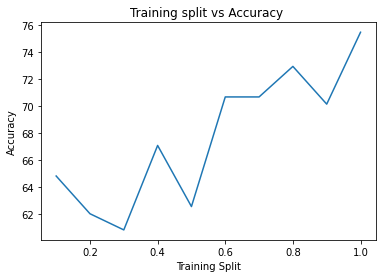

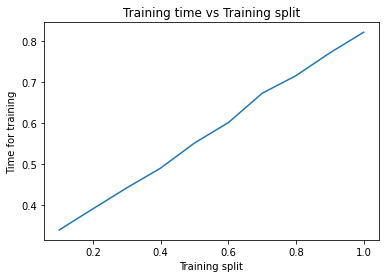

,Training_split,Mean(Accuracy) (%),Std(Accuracy) (%),Training Time (sec)
0,10,64.800,8.115,0.338516
1,20,62.000,9.503,0.390226
2,30,60.800,4.329,0.441310
3,40,67.067,3.058,0.489460
4,50,62.533,2.778,0.550574
5,60,70.667,7.495,0.600242
6,70,70.667,6.240,0.671752
7,80,72.933,3.617,0.714742
8,90,70.133,5.357,0.770193
9,100,75.467,0.499,0.820567


In [ ]:
def knn_face(train_data,k,image_height):
    train_shape = train_data.shape
    test_shape = face_data_test.shape
    num_images = training_face_labels.shape[0]
    testing_num_images = test_face_labels.shape[0]

    # converting the testdata into numpy array and flattened for calculations
#     train_face_np = np.zeros(shape=(int(train_shape[0]/image_height),train_shape[1]*image_height))
#     test_face_np = np.zeros(shape = (testing_num_images, test_shape[1]*image_height))    
    test_face_np = np.zeros(shape = (testing_num_images, 900))         
    for i in range(testing_num_images):
        test_face_np[i] = face_data_test.iloc[i*image_height +25 : i*image_height + 55 ,15:45].to_numpy().flatten()
    accuracy = []
    accuracy_std = []
    time_list = []  
    ratio = np.arange(0.1,1.05,0.1)   
    
    # flatten the training dataset
    for split in ratio:
        accuracy_inner = []
        time_inner = []
        for _ in range(5):         
            start_time = time.time()
            train_face_np = np.zeros(shape=(int((train_shape[0]/image_height)*split),900))    
            data_random_samples = random.sample(range(num_images), int(split * num_images))
            data_sample_range = [ range(i * image_height, (i+1)*image_height)  for i in data_random_samples]
            data_sample_range = list(chain(*data_sample_range))
            train_face_data = train_data.iloc[data_sample_range,:]       
            for i in range(int(num_images*split)):
                train_face_np[i] = train_face_data.iloc[i*image_height +25 : i*image_height +55, 15:45].to_numpy().flatten()

            error = 0
            for image_no in range(testing_num_images):
                each_image = test_face_np[image_no]
                neighbours_vector = np.zeros(int(num_images*split))
                for  j in range(int(num_images*split)):
                    neighbours_vector[j] = ((each_image - train_face_np[j])**2).sum()
                neighbour_df = pd.DataFrame(neighbours_vector)
                neighbour_df =  neighbour_df[0].sort_values()[0:k]
#                 print(neighbour_df)                
                class_labels = []
                for class_index in neighbour_df.index:
                    
                    # convert index to unrandomised for the label
#                     print(data_random_samples)
#                     print(data_random_samples[class_index], "class_index")
#                     print(class_index, training_face_labels.iloc[data_random_samples[class_index],:])
                    class_labels.append(training_face_labels.iloc[data_random_samples[class_index],0])
                predicted_class = pd.DataFrame(class_labels)
                predicted_value = predicted_class[0].value_counts().idxmax()
                # if the predicted class is not equal return training error
                if predicted_value != test_face_labels.iloc[image_no,:][0]:
                    error += 1
            accuracy_inner.append((1 - error/testing_num_images)*100)
            end_time = time.time()
            time_inner.append(end_time-start_time)
        
      
        accuracy.append(round(np.mean(accuracy_inner),3))
        accuracy_std.append(round(np.std(accuracy_inner),3))
        time_list.append(np.mean(time_inner))
        if split ==1 :
            break
    
    training_split = [ 10 * i for i in range(1,11,1)]
    final_results = pd.DataFrame(list(zip(training_split,accuracy, accuracy_std, time_list)),
                  columns = ['Training_split','Mean(Accuracy) (%)', 'Std(Accuracy) (%)', 'Training Time (sec)'])
    
        
    plt.plot(ratio,accuracy )
    plt.title("Training split vs Accuracy ")
    plt.xlabel("Training Split")
    plt.ylabel("Accuracy")
    plt.show()
    plt.plot(ratio,time_list )
    plt.title("Training time vs Training split")
    plt.xlabel("Training split")
    plt.ylabel("Time for training")
    plt.show()
    
    return final_results

knn_face(face_data_train,10,70)